# **Preprocessing**
### **1. Feature Handling**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import statsmodels.api as sm
import pylab as pl

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('IKEA_SA_Furniture_Web_Scrapings_sss.csv', index_col = 0)

In [6]:
df_ori = df.copy()

### **a. item_id** 

- Handle Data Duplication

In [7]:
df.drop_duplicates(subset=['item_id'], inplace = True)

In [8]:
df.item_id.duplicated().sum()

0

In [9]:
# Check new data dimension
df.shape

(2962, 13)

### **b. old_price**
- Handle Inconsistent Data
- Cast data type

In [10]:
def change_old_price(df):
    if df.old_price  == 'No old price':
        return df.price     # replace 'No old price' with price value
    elif df.old_price[-4:] != 'pack':
        return float(str(df.old_price[3:].replace(',','')))  # remove SR and change to float type
    else:
        return float(str(df.old_price).replace('SR ','').replace(' pack','').split('/')[0])  # remove SR & pack then change to float type
  
df.old_price = df.apply(change_old_price, axis=1)

In [11]:
df.head(2)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,265.0,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0


### **c. discount** 
- Feature engineering: Add discount feature

In [12]:
discount = pd.DataFrame(df.old_price-df.price)
df.insert (5, "discount", discount)

In [13]:
df.discount.dtypes

dtype('float64')

In [14]:
df[['price', 'old_price', 'discount']].describe()

,price,old_price,discount
count,2962.000000,2962.000000,2962.000000
mean,1108.722552,1161.414585,52.692032
std,1393.576103,1470.363828,183.105295
min,3.000000,3.000000,0.000000
25%,200.000000,205.000000,0.000000
50%,570.000000,595.000000,0.000000
75%,1475.000000,1543.750000,0.000000
max,9585.000000,9985.000000,1997.000000


### **d. discount_flag** 
- Feature engineering: Add discount_lag feature 

In [15]:
def add_discount_flag(df):
    if df.discount  == 0:
        return 0
    else:
        return 1

discount_flag = df.apply(add_discount_flag, axis=1)
df.insert (6, "discount_flag", discount_flag)

In [16]:
df.discount_flag.dtypes

dtype('int64')

### **e. Other Colors** 
- Feature engineering: Change Yes-No into True-False
- Cast data type

In [17]:
df.other_colors.dtypes

dtype('O')

In [18]:
def change_other_colors(df):
    if df.other_colors == 'Yes':
        return True
    else:
        return False

df.other_colors = df.apply(change_other_colors, axis=1)

In [19]:
df.head(4)

,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,265.0,0.0,0,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,69.0,0.0,0,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,True,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0


In [20]:
df.other_colors.dtypes

dtype('bool')

### **f. Short Description, description, overall_dim** 
- Feature engineering: Extract data from *short_description* into 2 new features *description* and *overall_dim*

In [21]:
# function to split data in 'short_description'
def dimension(df):                                      
    return str(df['short_description']).split(', ')[-1] 

# function to split data in 'short_description'
def description(df):                                    
    return str(df['short_description']).split(', ')[0]  


df.insert(10, 'description', df.apply(description, axis=1), True) # create 'description' feature
df.insert(11, 'overall_dim', df.apply(dimension, axis=1), True)   # create 'overall_dim' feature
df.drop(columns = 'short_description', inplace = True)             # drop/remove 'short_description' feature

In [22]:
df[25:30]

,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,description,overall_dim,designer,depth,height,width
25,10400540,EKEDALEN,Bar furniture,345.0,345.0,0.0,0,True,https://www.ikea.com/sa/en/p/ekedalen-bar-stoo...,False,Bar stool with backrest,75 cm,Ehlén Johansson,52.0,114.0,43.0
26,40400529,EKEDALEN,Bar furniture,796.0,995.0,199.0,1,True,https://www.ikea.com/sa/en/p/ekedalen-bar-tabl...,False,Bar table,120x80 cm,Ehlén Johansson,NaN,105.0,80.0
27,90319918,HENRIKSDAL,Bar furniture,695.0,695.0,0.0,0,True,https://www.ikea.com/sa/en/p/henriksdal-bar-st...,False,Bar stool with backrest,74 cm,Karl Malmvall,51.0,102.0,40.0
28,29297227,STENSELE / NORRARYD,Bar furniture,1340.0,1340.0,0.0,0,True,https://www.ikea.com/sa/en/p/stensele-norraryd...,False,Bar table and 2 bar stools,Bar table and 2 bar stools,Nike Karlsson/Maja Ganszyniec,NaN,NaN,NaN
29,99323925,STENSELE,Bar furniture,550.0,550.0,0.0,0,True,https://www.ikea.com/sa/en/p/stensele-bar-tabl...,False,Bar table,70x70 cm,Maja Ganszyniec,NaN,104.0,70.0


### **g. Depth, Height, Width** 
- Fill missing value with overall_dim

In [23]:
# function to split data in 'overall_dim'
def ov_dim(df):                                                   
    l = df.overall_dim
    l = l.replace(' cm','').replace(' mm','mm').replace('         ','').replace(' ', 'x')
    return re.split('/|x|-', l)                                        # select data dimension from 'overall_dim'

df.overall_dim = df.apply(ov_dim, axis=1)  

In [24]:
# remove unecessary data from overall_dim and return it to 0
def rem_len(df):
    if len(df.overall_dim) > 4:
        return ['0']                                       
    else:
        return df.overall_dim
    
df.overall_dim = df.apply(rem_len, axis=1)  

In [25]:
# remove leftover unecessary data from overall_dim and return it to 0
def rem_char(df):
    my_list = df.overall_dim[0]
    if any('a' in s for s in my_list) or any('i' in s for s in my_list) or any('u' in s for s in my_list) or any('e' in s for s in my_list) or any('o' in s for s in my_list):
        return ['0']                                                                          
    else:
        return df.overall_dim
   
df.overall_dim = df.apply(rem_char, axis=1)  

In [26]:
# function to fill Nan value in height feature according data in overall_dim
def choose_h(df):                       
    lenList = len(df.overall_dim)
    
    if lenList == 1:
        return df.overall_dim[0]
    
    elif  lenList == 2:
        return df.overall_dim[1]
        
    elif lenList == 3:
        return df.overall_dim[2]

    elif lenList == 4:
        return df.overall_dim[3]
        
    else:
        return df.height

# function to fill Nan value in depth feature according data in overall_dim       
def choose_d(df):                       
    lenList = len(df.overall_dim)
    
    if lenList == 1:
        return df.overall_dim[0]
    
    elif lenList == 2:
        return df.overall_dim[0]
        
    elif lenList == 3:
        return df.overall_dim[0]

    elif lenList == 4:
        return df.overall_dim[2]
        
    else:
        return df.depth

# function to fill Nan value in width feature according data in overall_dim
def choose_w(df):                          
    lenList = len(df.overall_dim)
    
    if lenList == 1:
        return df.overall_dim[0]
    
    elif  lenList == 2:
        return df.overall_dim[1]
        
    elif lenList == 3:
        return df.overall_dim[1]

    elif lenList == 4:
        return df.overall_dim[1]
        
    else:
        return df.width
        
listCol = ['height','depth', 'width'] 
for i in listCol:
    if i == 'height':
        df[i] = df[i].fillna(df.apply(choose_h, axis=1)) 
    elif i == 'depth':
        df[i] = df[i].fillna(df.apply(choose_d, axis=1)) 
    else:
        df[i] = df[i].fillna(df.apply(choose_w, axis=1))
      

In [27]:
# Change format into str to recheck if unwanted value filled into these columns
df['height'] = df['height'].astype(str)         
df['depth'] = df['depth'].astype(str)           
df['width'] = df['width'].astype(str)

In [28]:
# Remove leftover unwanted value and change it to 0
df.loc[df['height'].str.contains('seat|pack|sofa|"'), 'height'] = 0   
df.loc[df['width'].str.contains('seat|pack|sofa|"'), 'width'] = 0
df.loc[df['depth'].str.contains('seat|pack|sofa|"'), 'depth'] = 0

In [29]:
# function to convert some of value in height, dept, width from mm to cm
def mm_to_cm_h(df):                          
    a = str(df.height)
    b = a[-2:]
    if b == 'mm':
        c = a.split('mm')
        c = str(int(c[0])/10)
        return c
    else:
        return str(df.height)

# function to convert some of value in height, dept, width from mm to cm
def mm_to_cm_d(df):                         
    a = str(df.depth)
    b = a[-2:]
    if b == 'mm':
        c = a.split('mm')
        c = str(int(c[0])/10)
        return c
    else:
        return str(df.depth)    

# function to convert some of value in height, dept, width from mm to cm    
def mm_to_cm_w(df):                         
    a = str(df.width)
    b = a[-2:]
    if b == 'mm':
        c = a.split('mm')
        c = str(int(c[0])/10)
        return c
    else:
        return str(df.width)

In [30]:
df.height = df.apply(mm_to_cm_h, axis=1)  
df.depth = df.apply(mm_to_cm_d, axis=1)  
df.width = df.apply(mm_to_cm_w, axis=1)

In [31]:
# change datatype into float
df.height = df.height.astype(float)  
df.depth = df.depth.astype(float)
df.width = df.width.astype(float)

In [32]:
df = df.drop(columns = 'overall_dim')

In [33]:
# change value which has 0 value into np.nan
a = df.depth    
a[a == 0] = np.nan
df.depth = a

b = df.height
b[b == 0] = np.nan
df.height = b

c = df.width
c[c == 0] = np.nan
df.width = c

In [34]:
# Check missing value and data types again
count_missing_value = df.isnull().sum()
proportion = (df.isnull().sum() / len(df)) * 100
data_types = df.dtypes

missing_values_concat = pd.concat([count_missing_value, proportion, data_types], axis=1)
missing_values = missing_values_concat.rename(columns = {0 : 'missing_values', 
                                                         1 : 'proportion_(%)',
                                                         2 : 'data_types'})
missing_values = missing_values.sort_values(by='proportion_(%)', ascending=False)
missing_values

,missing_values,proportion_(%),data_types
depth,294,9.925726,float64
height,294,9.925726,float64
width,243,8.203916,float64
item_id,0,0.000000,int64
name,0,0.000000,object
category,0,0.000000,object
price,0,0.000000,float64
old_price,0,0.000000,float64
discount,0,0.000000,float64
discount_flag,0,0.000000,int64


In [35]:
# fill nan value with median of column
df.depth = df.depth.fillna(value = df.depth.median())    
df.height = df.height.fillna(value = df.height.median())
df.width = df.width.fillna(value = df.width.median())

- Creating new column (Volume)

In [36]:
df['volume'] = df['depth'] * df['height'] * df['width']

In [37]:
df.head()

,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,description,designer,depth,height,width,volume
0,90420332,FREKVENS,Bar furniture,265.0,265.0,0.0,0,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,Bar table,Nicholai Wiig Hansen,51.0,99.0,51.0,257499.0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,Bar table,Francis Cayouette,140.0,105.0,80.0,1176000.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,55.0,83.0,80.0,365200.0
3,80155205,STIG,Bar furniture,69.0,69.0,0.0,0,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,True,Bar stool with backrest,Henrik Preutz,50.0,100.0,60.0,300000.0
4,30180504,NORBERG,Bar furniture,225.0,225.0,0.0,0,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,False,Wall-mounted drop-leaf table,Marcus Arvonen,60.0,43.0,74.0,190920.0


### **h. designer**
- Clean the data

In [38]:
import re
def clean_designer(df):
    if len(df.designer) <= 57 or df.designer in 'IKEA of Sweden':
        check = re.findall(r'(\d{3}.\d{3}.\d{2})', df.designer)
        if (len(check)) == 0:
            return str(df.designer.replace('IKEA of Sweden','').replace('None', 'No Designer'))
        else:
            return 'No Designer'                 
    else:
        return 'No Designer'

def split_designer(df):                                      
    return str(df.designer).split('/')[0].replace('/','')

df.designer = df.apply(clean_designer, axis=1)
df.designer = df.apply(split_designer, axis=1)

In [39]:
def last_clean(df):
    if df.designer == '':
        return 'No Designer'                 
    else:
        return df.designer

df.designer = df.apply(last_clean, axis=1)

In [40]:
df[31:35]

,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,description,designer,depth,height,width,volume
31,39184324,HENRIKSDAL,Bar furniture,435.0,435.0,0.0,0,True,https://www.ikea.com/sa/en/p/henriksdal-bar-st...,False,Bar stool with backrest,No Designer,51.0,102.0,40.0,208080.0
32,19297275,NORRÅKER / NORRÅKER,Bar furniture,1266.0,1385.0,119.0,1,True,https://www.ikea.com/sa/en/p/norraker-norraker...,False,Bar table and 2 bar stools,J Karlsson,74.0,74.0,74.0,405224.0
33,60400745,YNGVAR,Bar furniture,475.0,475.0,0.0,0,True,https://www.ikea.com/sa/en/p/yngvar-bar-stool-...,False,Bar stool,No Designer,40.0,75.0,40.0,120000.0
34,20336619,HENRIKSDAL,Bar furniture,40.0,40.0,0.0,0,True,https://www.ikea.com/sa/en/p/henriksdal-cover-...,False,Cover for bar stool with backrest,No Designer,55.0,83.0,80.0,365200.0


# **Methodology (Data Analytics)**
### **1. Analysis Paradigm**

In [41]:
df.head(10)

,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,description,designer,depth,height,width,volume
0,90420332,FREKVENS,Bar furniture,265.0,265.0,0.0,0,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,Bar table,Nicholai Wiig Hansen,51.0,99.0,51.0,257499.0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,Bar table,Francis Cayouette,140.0,105.0,80.0,1176000.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,55.0,83.0,80.0,365200.0
3,80155205,STIG,Bar furniture,69.0,69.0,0.0,0,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,True,Bar stool with backrest,Henrik Preutz,50.0,100.0,60.0,300000.0
4,30180504,NORBERG,Bar furniture,225.0,225.0,0.0,0,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,False,Wall-mounted drop-leaf table,Marcus Arvonen,60.0,43.0,74.0,190920.0
5,10122647,INGOLF,Bar furniture,345.0,345.0,0.0,0,True,https://www.ikea.com/sa/en/p/ingolf-bar-stool-...,False,Bar stool with backrest,Carina Bengs,45.0,91.0,40.0,163800.0
6,70404875,FRANKLIN,Bar furniture,129.0,129.0,0.0,0,True,https://www.ikea.com/sa/en/p/franklin-bar-stoo...,False,Bar stool with backrest,K Hagberg,44.0,95.0,50.0,209000.0
7,60155602,DALFRED,Bar furniture,195.0,195.0,0.0,0,True,https://www.ikea.com/sa/en/p/dalfred-bar-stool...,False,Bar stool,Sarah Fager,50.0,74.0,50.0,185000.0
8,50406465,FRANKLIN,Bar furniture,129.0,129.0,0.0,0,True,https://www.ikea.com/sa/en/p/franklin-bar-stoo...,False,Bar stool with backrest,K Hagberg,44.0,95.0,50.0,209000.0
9,69304221,EKEDALEN / EKEDALEN,Bar furniture,2176.0,2375.0,199.0,1,True,https://www.ikea.com/sa/en/p/ekedalen-ekedalen...,False,Bar table and 4 bar stools,Ehlén Johansson,55.0,83.0,80.0,365200.0


In [42]:
df.dtypes

item_id              int64
name                object
category            object
price              float64
old_price          float64
discount           float64
discount_flag        int64
sellable_online       bool
link                object
other_colors          bool
description         object
designer            object
depth              float64
height             float64
width              float64
volume             float64
dtype: object

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2962 entries, 0 to 3692
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   item_id          2962 non-null   int64  
 1   name             2962 non-null   object 
 2   category         2962 non-null   object 
 3   price            2962 non-null   float64
 4   old_price        2962 non-null   float64
 5   discount         2962 non-null   float64
 6   discount_flag    2962 non-null   int64  
 7   sellable_online  2962 non-null   bool   
 8   link             2962 non-null   object 
 9   other_colors     2962 non-null   bool   
 10  description      2962 non-null   object 
 11  designer         2962 non-null   object 
 12  depth            2962 non-null   float64
 13  height           2962 non-null   float64
 14  width            2962 non-null   float64
 15  volume           2962 non-null   float64
dtypes: bool(2), float64(7), int64(2), object(5)
memory usage: 35

In [44]:
df.columns

Index(['item_id', 'name', 'category', 'price', 'old_price', 'discount',
       'discount_flag', 'sellable_online', 'link', 'other_colors',
       'description', 'designer', 'depth', 'height', 'width', 'volume'],
      dtype='object')

In [45]:
df.isnull().sum().sum()

0

In [46]:
df.describe()

,item_id,price,old_price,discount,discount_flag,depth,height,width,volume
count,2.962000e+03,2962.000000,2962.000000,2962.000000,2962.000000,2962.000000,2962.000000,2962.000000,2.962000e+03
mean,4.877244e+07,1108.722552,1161.414585,52.692032,0.193788,70.664315,101.457124,105.710128,9.759525e+05
std,2.896535e+07,1393.576103,1470.363828,183.105295,0.395331,46.459605,64.411070,70.863921,1.654647e+06
min,5.848700e+04,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,8.000000e+00
25%,2.039630e+07,200.000000,205.000000,0.000000,0.000000,41.250000,68.000000,60.000000,2.017680e+05
50%,4.928075e+07,570.000000,595.000000,0.000000,0.000000,55.000000,83.000000,80.000000,4.103800e+05
75%,7.042306e+07,1475.000000,1543.750000,0.000000,0.000000,88.000000,120.000000,142.000000,1.140984e+06
max,9.993262e+07,9585.000000,9985.000000,1997.000000,1.000000,420.000000,700.000000,420.000000,2.358794e+07


In [47]:
df.describe(include = 'object')

,name,category,link,description,designer
count,2962,2962,2962,2962,2962
unique,607,17,2962,663,83
top,BESTÅ,Bookcases & shelving units,https://www.ikea.com/sa/en/p/klimpen-torsklint...,Table,No Designer
freq,115,548,1,141,1087


**- Category -**

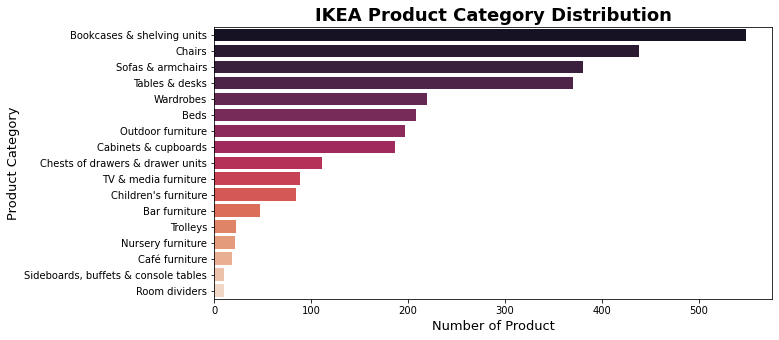

In [48]:
plt.figure(figsize=[10, 5])
ax = sns.countplot(y=df.category, order=df.category.value_counts().index, palette='rocket')
plt.title('IKEA Product Category Distribution',fontsize=18, fontweight='bold')
plt.xlabel('Number of Product', fontsize=13)
plt.ylabel('Product Category', fontsize=13)
plt.show()

dari seluruh total data produk, jika dibagi dalam kategori, jumlah produk terdistribusi paling banyak ke dalam kategori bookcases & shelving units, chairs, dan Sofa & armchairs. sebelum preprocessing, table & desks berada pada urutan ke 1 sekarang menjadi urutan ke 4

**- Price -**

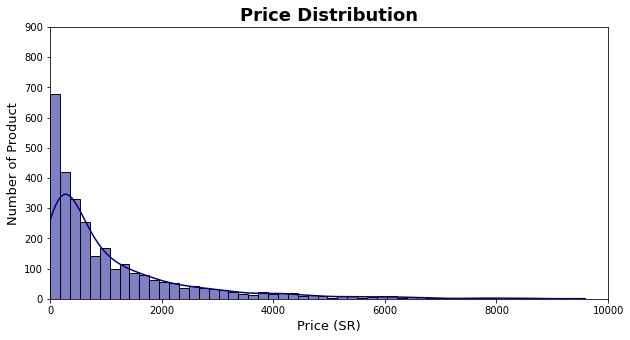

In [49]:
plt.figure(figsize=[10, 5])
sns.histplot(df.price, kde=True, color='darkblue')

plt.title('Price Distribution', fontsize = 18, fontweight='bold')
plt.xlabel('Price (SR)', fontsize = 13)
plt.ylabel('Number of Product', fontsize = 13)
plt.xlim(0,10000)
plt.ylim(0,900)
plt.show()

walaupun telah di bersihkan dan di preprocessing, data harga tetap menunjukkan tidak terdistribusi normal. namun demikian, grafik ini menunjukkan perbaikan dibanding sebelum dibersihkan dan di preprocessing. grafik ini jauh lebih landai dan tingkat kemiringannya jauh lebih sedikit.

**- Old Price -**

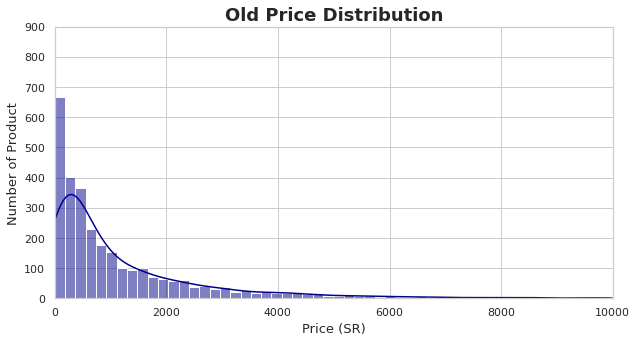

In [51]:
plt.figure(figsize=[10, 5])
sns.histplot(df.old_price, kde=True, color='darkblue')

plt.title('Old Price Distribution', fontsize = 18, fontweight='bold')
plt.xlabel('Price (SR)', fontsize = 13)
plt.ylabel('Number of Product', fontsize = 13)
plt.xlim(0,10000)
plt.ylim(0,900)
plt.show()

pada grafik old_price, tidak jauh berbeda dengan grafik price pada distribusi normalitasnya. hanya saja ekor harga old_price jauh lebih tinggi daripada price karena old_price masih belum memperhitungkan diskon yang akan mengurangi harga old_price

**- discount -**

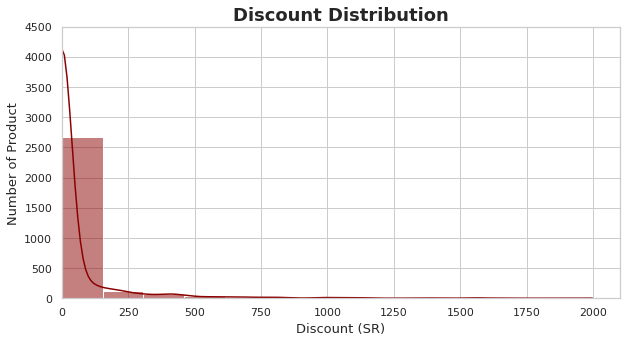

In [52]:
plt.figure(figsize=[10, 5])
sns.histplot(df.discount, kde=True, color='darkred')

plt.title('Discount Distribution', fontsize = 18, fontweight='bold')
plt.xlabel('Discount (SR)', fontsize = 13)
plt.ylabel('Number of Product', fontsize = 13)
plt.xlim(0,2100)
plt.ylim(0,4500)
plt.show()

dari keseluruhan produk, lebih dari 2500 produk dikenakan diskon < dari 250 SR. hanya sedikit produk yang mendapatkan diskon lebih dari 250 SR dan seterusnya

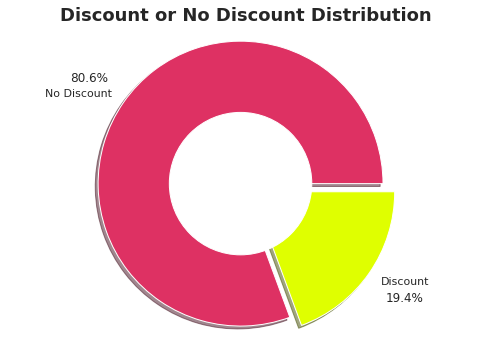

In [53]:
discount_or_no = df.discount_flag.value_counts()

colors = ['#DE3163', '#DFFF00']
# only "explode" 
explode = (0, 0.1)  

plt.figure(figsize=[7, 5])
plt.pie(discount_or_no, explode=explode, labels=['No Discount', 'Discount'], autopct='%1.1f%%', colors=colors, pctdistance=1.3, shadow=True)
plt.title('Discount or No Discount Distribution', fontsize = 18, fontweight='bold')

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

dari 2962 produk, 80,6% mayoritas produk mendapatkan tidak mendapat diskon. sedangkan 19,4% nya didiskon

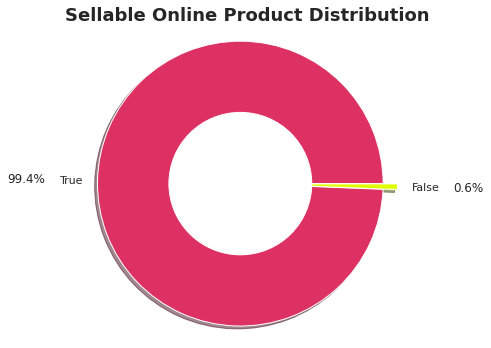

In [54]:
sellable_online_or_no = df['sellable_online'].value_counts()

colors = ['#DE3163', '#DFFF00']
# only "explode" 
explode = (0, 0.1)  

plt.figure(figsize=[7, 5])
plt.pie(sellable_online_or_no, explode=explode, labels=['True', 'False'], autopct='%1.1f%%', colors=colors, pctdistance=1.5, shadow=True)
plt.title('Sellable Online Product Distribution', fontsize = 18, fontweight='bold')

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

setelah data produk dibersihkan dan di preprocessing, produk yang dapat dijual online meningkat lebih banyak dari yang awalnya 99,2% menjadi 99,4%

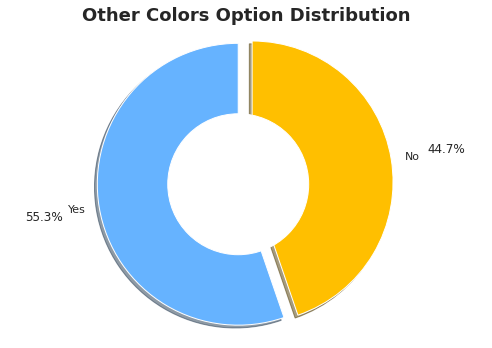

In [55]:
other_colors_or_no = df['other_colors'].value_counts()

colors = ['#66b3ff', '#FFBF00']
# only "explode" 
explode = (0, 0.1)  

plt.figure(figsize=[7, 5])
plt.pie(other_colors_or_no, explode=explode, labels=['Yes', 'No'], autopct='%1.1f%%', colors=colors, pctdistance=1.4, shadow=True, startangle=90)
plt.title('Other Colors Option Distribution', fontsize = 18, fontweight='bold')

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

namun terjadi penurunan persentase produk yang tersedia pilihan warnanya setelah dilakukan pembersihan dan preprocessing dari 59,1% menjadi 55,3%

[Text(0.5, 0, 'Width'), Text(0.5, 1.0, 'Width Plot')]

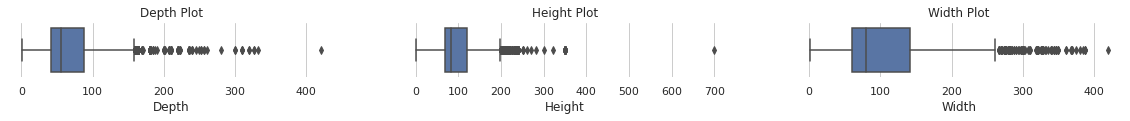

In [56]:
sns.set(style="whitegrid", font_scale=1)
f, ax = plt.subplots(1, 3,figsize=(20,1))
sns.boxplot(x=df['depth'], ax=ax[0])
sns.boxplot(x=df['height'], ax=ax[1])
sns.boxplot(x=df['width'], ax=ax[2])
sns.despine(bottom=True, left=True)

ax[0].set(xlabel='Depth', title='Depth Plot')
ax[1].set(xlabel='Height', title='Height Plot')
ax[2].set(xlabel='Width', title='Width Plot')

distribusi dimensi pada setiap produk tetap memiliki banyak outlier walaupun sudah dilakukan pembersihan dan preprocessing. rentang paling lebar terdapat pada dimensi width

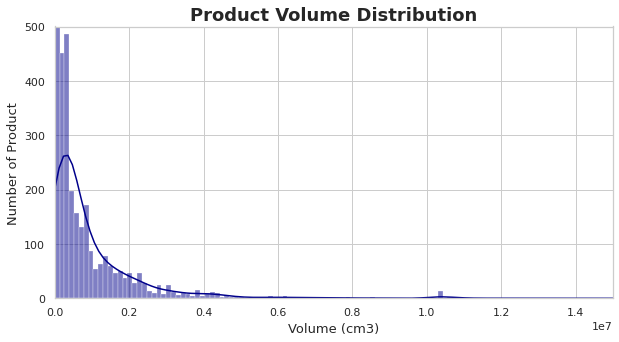

In [57]:
plt.figure(figsize=[10, 5])
sns.histplot(df.volume, kde=True, color='darkblue')

plt.title('Product Volume Distribution', fontsize = 18, fontweight='bold')
plt.xlabel('Volume (cm3)', fontsize = 13)
plt.ylabel('Number of Product', fontsize = 13)
plt.xlim(0,15000000)
plt.ylim(0,500)
plt.show()

dengan membentuk dimensi baru yaitu volume, volume mencerminkan perkalian antara height, depth, dan width. pada grafik ini terlihat distribusi produk pada volume tidak normal dimana hampir 500 produk atau mayoritas memiliki volume pada rentang 0,0 - 0,2 cm3

[Text(0.5, 0, 'Volume (cm3)'), Text(0.5, 1.0, 'Volume Plot')]

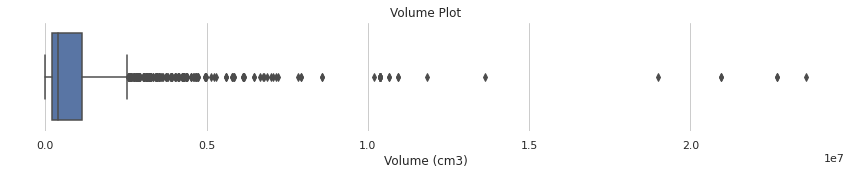

In [58]:
sns.set(style="whitegrid", font_scale=1) 
f, ax = plt.subplots(1, 1, figsize=(15,2))
sns.boxplot(x=df.volume)
sns.despine(bottom=True, left=True)
ax.set(xlabel='Volume (cm3)', title='Volume Plot')

volume yang tidak terdistribusi normal jelas terlihat pada boxplot volume

**- Feature againts Price -**

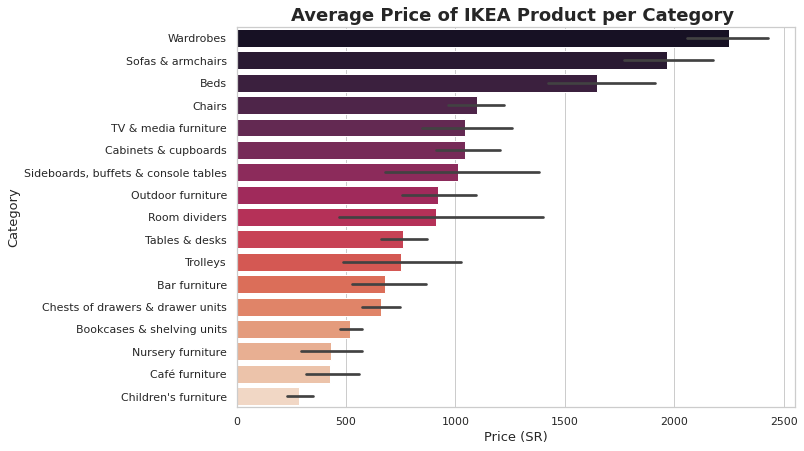

In [59]:
plt.figure(figsize=[10, 7])
result = df.groupby(["category"])['price'].aggregate(np.mean).reset_index().sort_values('price', ascending=False)
sns.barplot(data=df, y='category', x='price', order=result['category'], palette='rocket')
plt.title('Average Price of IKEA Product per Category ', fontsize = 18, fontweight='bold')
plt.xlabel('Price (SR)', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.show()

rata-rata harga tertinggi terdapat pada kategori wardrobes, sofas & armchairs dan beds (tidak berbeda dengan sebelum pembersihan data dan preprocessing).  rentang harga tertinggi produk terdapat pada kategori room dividers, trolley, bers dan sideboards, buffets & console tables

[Text(0, 0.5, 'Category'),
 Text(0.5, 0, 'Price'),
 Text(0.5, 1.0, 'Category vs Price Boxplot')]

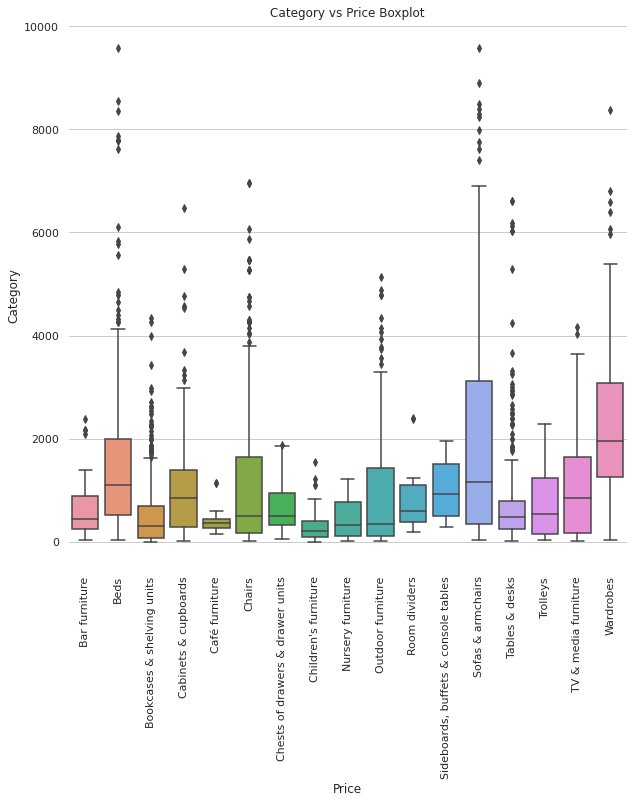

In [60]:
sns.set(style="whitegrid", font_scale=1)
f, ax = plt.subplots(1, 1,figsize=(10,10))
sns.boxplot(x=df['category'],y=df['price'], ax=ax)
sns.despine(left=True, bottom=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Price', ylabel='Category', title='Category vs Price Boxplot')

dari grafik ini erlihat sofa & armchairs disusul dengan wardrobes dan beds memliki rentang harga yang lebar dan putlier yang sangat tinggi. semua kategori memiliki data outlier kecuali pada kategori nursery furniture, sideboards, buffet, & console tablets, dan trolleys.

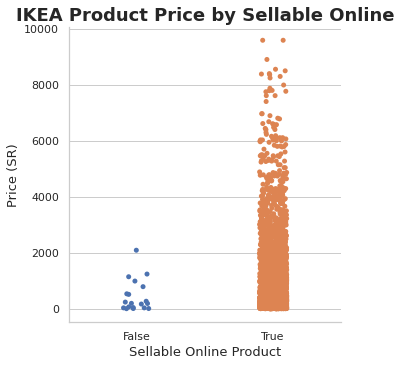

In [61]:
sns.catplot(x="sellable_online", y="price", data=df)
plt.title('IKEA Product Price by Sellable Online', fontsize = 18, fontweight='bold')
plt.xlabel('Sellable Online Product', fontsize = 13)
plt.ylabel('Price (SR)', fontsize = 13)
plt.show()

produk-produk yang dijual online memiliki kecenderungan harga jual yang lebih tinggi dibandingkan dengan harga produk yang tidak dijual secara online

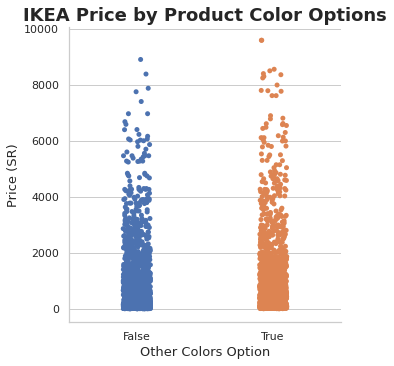

In [62]:
sns.catplot(x="other_colors", y="price", data=df)
plt.title('IKEA Price by Product Color Options', fontsize = 18, fontweight='bold')
plt.xlabel('Other Colors Option', fontsize = 13)
plt.ylabel('Price (SR)', fontsize = 13)
plt.show()

pada sisi ketersediaan pilihan warna, produk yang dapat memilih warna memiliki kecenderungan harga yang sedikit lebih tinggi dibandingkan dengan produk yang hanya ada 1 pilihan warna

[Text(0, 0.5, 'Price'),
 Text(0.5, 0, 'Other Colors'),
 Text(0.5, 1.0, 'Other Colors vs Price Box Plot')]

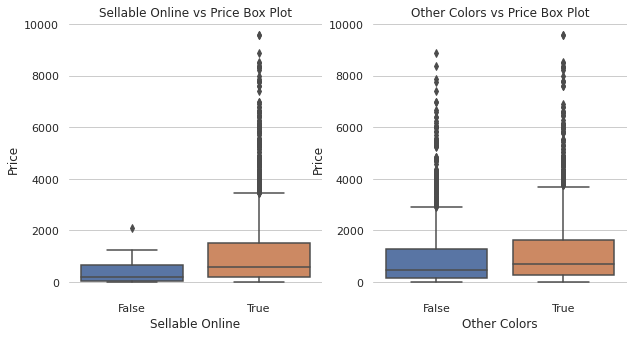

In [63]:
sns.set(style="whitegrid", font_scale=1)
f, ax = plt.subplots(1, 2,figsize=(10,5))
sns.boxplot(x=df['sellable_online'],y=df['price'], ax=ax[0])
sns.boxplot(x=df['other_colors'],y=df['price'], ax=ax[1])
sns.despine(bottom=True, left=True)
ax[0].set(xlabel='Sellable Online', ylabel='Price', title='Sellable Online vs Price Box Plot')
ax[1].set(xlabel='Other Colors', ylabel='Price', title='Other Colors vs Price Box Plot')

dari grafik terlihat rentang rata-rata harga produk yang dijual online jauh lebih tinggi dibandingkan yang tidak dijual online. sedangkan produk yang memiliki pilihan warna memiliki harga rata-rata yang lebih tinggi dibandingkan produk yang hanya memiliki 1 warna

[Text(0, 0.5, 'Price'),
 Text(0.5, 0, 'Width (cm)'),
 Text(0.5, 1.0, 'Width vs Price Box Plot')]

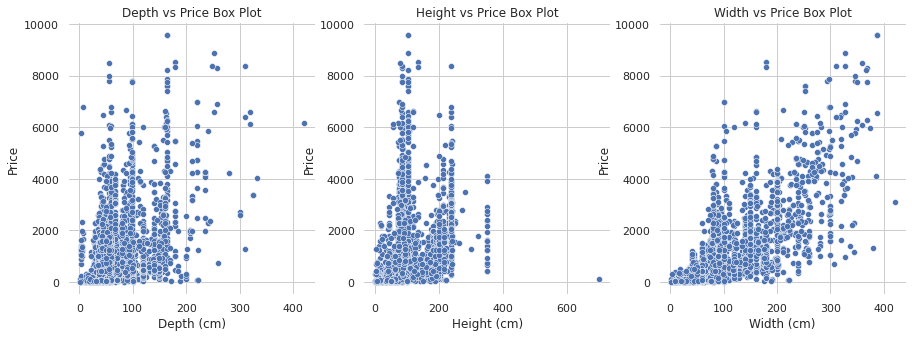

In [64]:
sns.set(style="whitegrid", font_scale=1)
f, ax = plt.subplots(1, 3, figsize=(15,5))
sns.scatterplot(x=df['depth'],y=df['price'], ax=ax[0])
sns.scatterplot(x=df['height'],y=df['price'], ax=ax[1])
sns.scatterplot(x=df['width'],y=df['price'], ax=ax[2])
sns.despine(bottom=True, left=True)
ax[0].set(xlabel='Depth (cm)', ylabel='Price', title='Depth vs Price Box Plot')
ax[1].set(xlabel='Height (cm)', ylabel='Price', title='Height vs Price Box Plot')
ax[2].set(xlabel='Width (cm)', ylabel='Price', title='Width vs Price Box Plot')

di antara ketiga dimensi, dimensi width lebih menunjukkan pola yang positif terhadap harga dibandingkan depth dan height.

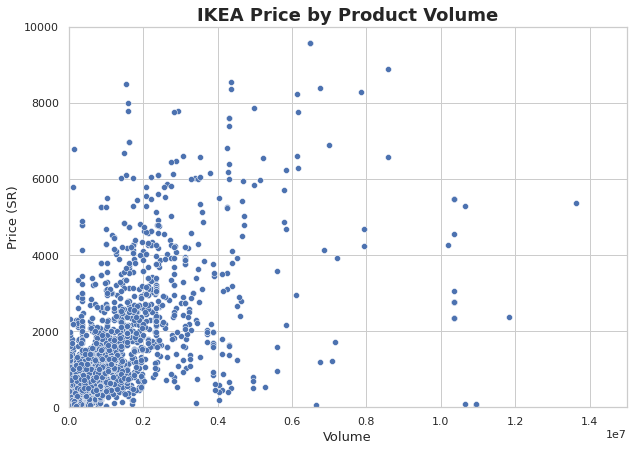

In [65]:
plt.figure(figsize=[10, 7])
sns.scatterplot(x="volume", y="price", data=df)
plt.title('IKEA Price by Product Volume', fontsize = 18, fontweight='bold')
plt.xlabel('Volume', fontsize = 13)
plt.ylabel('Price (SR)', fontsize = 13)
plt.xlim(0,15000000)
plt.ylim(0,10000)
plt.show()

sedangkan jika dibandingkan dengan volume, walaupun korelasi antara volume dan harga terlihat acak namun terdapat hubungan yang positif antara volume dan harga

**- Feature againts Feature -**

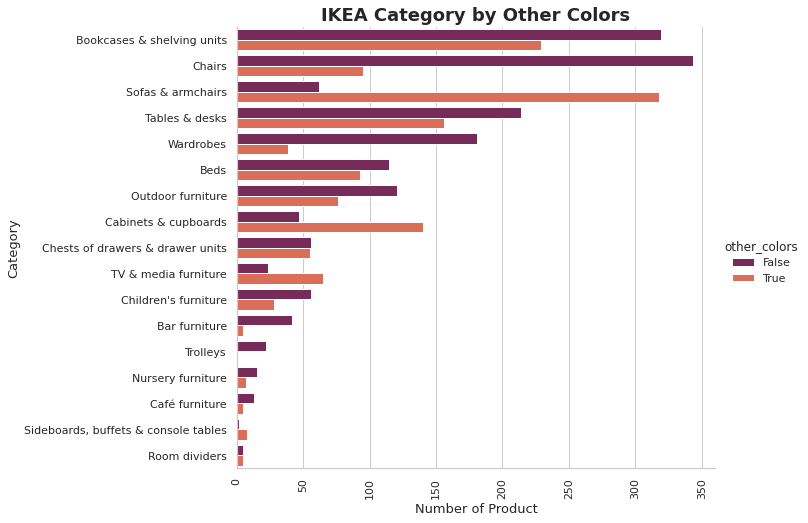

In [66]:
order = df['category'].value_counts().index
sns.catplot(data=df, y="category", hue='other_colors', kind="count", order=order, palette='rocket', height=7, aspect=1.5)

plt.title('IKEA Category by Other Colors', fontsize = 18, fontweight='bold')
plt.xlabel('Number of Product', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.xticks(rotation=90)
plt.show()

kategori produk yang dapat memilih warna rata-rata lebih banyak produknya pada kategori sofas & armchairs, cabinet & cupboards, dan TV & media furniture. sedangkan pada kategori sisanya rata-rata lebih banyak yang hanya 1 warna. 

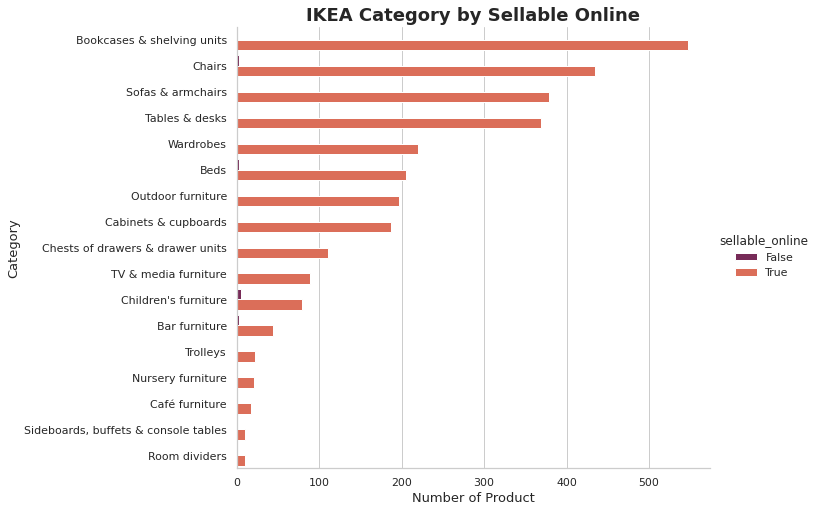

In [67]:
order = df['category'].value_counts().index
sns.catplot(data=df, y="category", hue='sellable_online', kind="count", order=order, palette='rocket', height=7, aspect=1.5)

plt.title('IKEA Category by Sellable Online', fontsize = 18, fontweight='bold')
plt.xlabel('Number of Product', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.show()

hampir seluruh kategori produk mayoritas dijual secara online

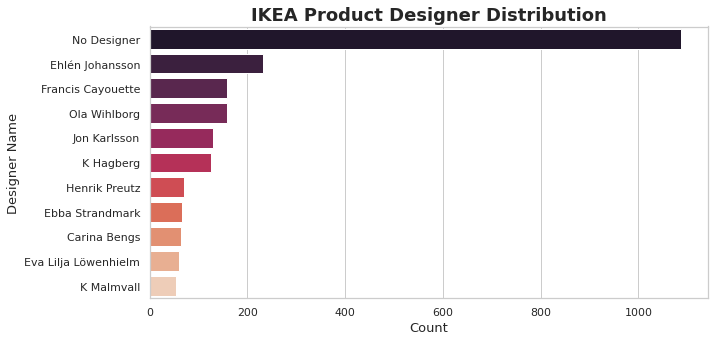

In [68]:
plt.figure(figsize=[10, 5])
sns.countplot(y=df.designer, order=df.designer.value_counts()[0:11].index, palette='rocket')
plt.title('IKEA Product Designer Distribution',fontsize=18, fontweight='bold')
plt.xlabel('Count', fontsize=13)
plt.ylabel('Designer Name', fontsize=13)
plt.show()

terdapat 1000 lebih produk yang tidak memiliki desainer. desainer yang mendesain produk terbanyak adalah Ehlen Johansson, Francis Cayoutte, dan Ola Wihlborg

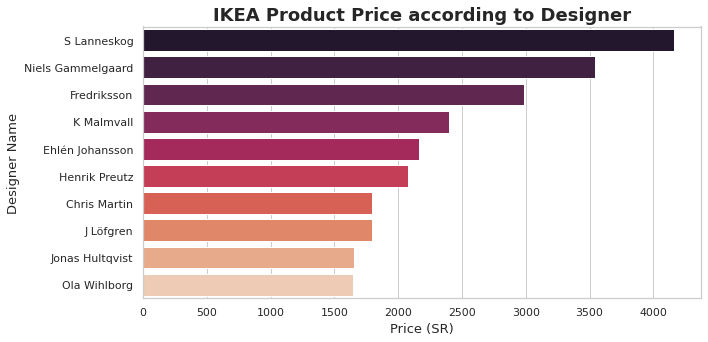

,designer,price
71,S Lanneskog,4165.000000
60,Niels Gammelgaard,3546.000000
21,Fredriksson,2986.400000
40,K Malmvall,2402.090909
16,Ehlén Johansson,2167.416309
...,...,...
1,A Huldén,55.000000
68,S Edholm,51.250000
10,Charlie Styrbjörn,35.000000
5,Annie Huldén,27.500000


In [69]:
plt.figure(figsize=[10, 5])
result = df.groupby(["designer"])['price'].aggregate(np.mean).reset_index().sort_values('price', ascending=False)

sns.barplot(data = result, x = 'price', y='designer', order=result.designer[0:10], palette='rocket')
plt.title('IKEA Product Price according to Designer',fontsize=18, fontweight='bold')
plt.xlabel('Price (SR)', fontsize=13)
plt.ylabel('Designer Name', fontsize=13)
plt.show()

result

S Lanneskog merupakan desainer produk yang memiliki harga rata-rata tertinggi (4165 SR) disusul oleh Niels Gammelgaard (2546 SR) dan Fredriksson (2986 SR)

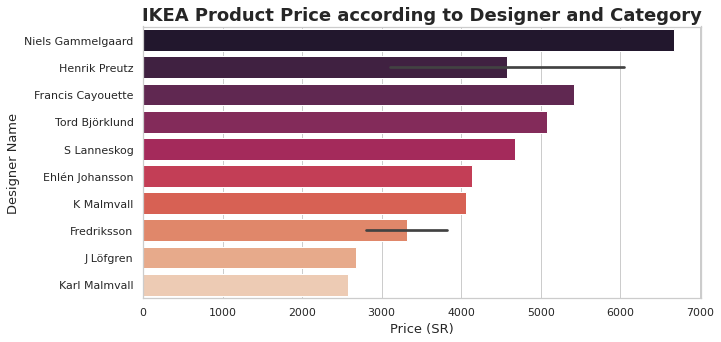

,designer,category,price
217,Niels Gammelgaard,Sofas & armchairs,6680.000000
103,Henrik Preutz,Beds,6051.000000
77,Francis Cayouette,Beds,5423.333333
294,Tord Björklund,Sofas & armchairs,5075.000000
265,S Lanneskog,Chairs,4670.714286
60,Ehlén Johansson,Beds,4138.000000
160,K Malmvall,Cabinets & cupboards,4060.833333
84,Fredriksson,Beds,3823.000000
110,Henrik Preutz,Sofas & armchairs,3104.972222
86,Fredriksson,Sofas & armchairs,2803.600000


In [70]:
plt.figure(figsize=[10, 5])
result = df.groupby(["designer", 'category'])['price'].aggregate(np.mean).reset_index().sort_values('price', ascending=False)[:12]

sns.barplot(data = result, x = 'price', y='designer',  palette='rocket')
plt.title('IKEA Product Price according to Designer and Category',fontsize=18, fontweight='bold')
plt.xlabel('Price (SR)', fontsize=13)
plt.ylabel('Designer Name', fontsize=13)
plt.show()

result[:10]

Niels Gammelgaard sendiri mendesain produk Sofas & Armchairs dengan harga rata-rata yang paling tinggi diantara desainer per kategorinya yaitu 6680 SR. disusul oleh Henrik Preutz yg mendesain Beds (6051) dan Francis Cayoutte yang juga mendsain Beds (5423)

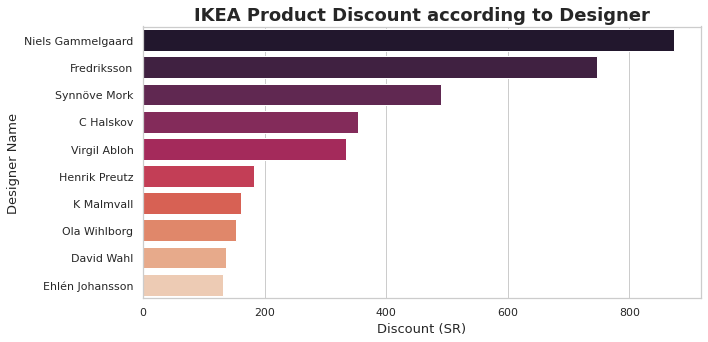

,designer,discount
60,Niels Gammelgaard,874.000000
21,Fredriksson,746.600000
74,Synnöve Mork,490.333333
6,C Halskov,354.250000
81,Virgil Abloh,334.400000
...,...,...
47,Lycke von Schantz,0.000000
48,M Kjelstrup,0.000000
49,Magnus Elebäck,0.000000
51,Malin Unnborn,0.000000


In [71]:
plt.figure(figsize=[10, 5])
result = df.groupby(["designer"])['discount'].aggregate(np.mean).reset_index().sort_values('discount', ascending=False)

sns.barplot(data = result, x = 'discount', y='designer', order=result.designer[0:10], palette='rocket')
plt.title('IKEA Product Discount according to Designer',fontsize=18, fontweight='bold')
plt.xlabel('Discount (SR)', fontsize=13)
plt.ylabel('Designer Name', fontsize=13)
plt.show()

result

namun demikian, produk yang didesain oleh Niels Gammelgaard	juga adalah jumlah produk yang diskon tertinggi yaitu 874 produk.

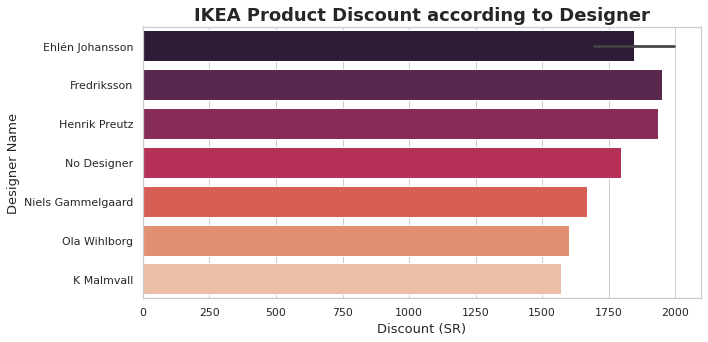

,designer,price,discount
386,Ehlén Johansson,7988.0,1997.0
594,Fredriksson,7796.0,1949.0
710,Henrik Preutz,7748.0,1937.0
1629,No Designer,2697.0,1798.0
384,Ehlén Johansson,6780.0,1695.0
1188,Niels Gammelgaard,6680.0,1670.0
1827,Ola Wihlborg,6400.0,1600.0
1052,K Malmvall,6608.0,1572.0
711,Henrik Preutz,7873.0,1557.0
707,Henrik Preutz,6228.0,1557.0


In [72]:
plt.figure(figsize=[10, 5])
result = df.groupby(['designer', 'price'])['discount'].aggregate(np.mean).reset_index().sort_values('discount', ascending=False)[0:10]

sns.barplot(data = result[0:8], x = 'discount', y='designer', palette='rocket')
plt.title('IKEA Product Discount according to Designer',fontsize=18, fontweight='bold')
plt.xlabel('Discount (SR)', fontsize=13)
plt.ylabel('Designer Name', fontsize=13)
plt.show()

result

jika dikelompokkan data dengan diskon tertinggi, Ehlen Johansson, Fredriksson, dan Henrik Preutz merupakan designer yang produknya memiliki rata-rata tingkat diskon tertinggi

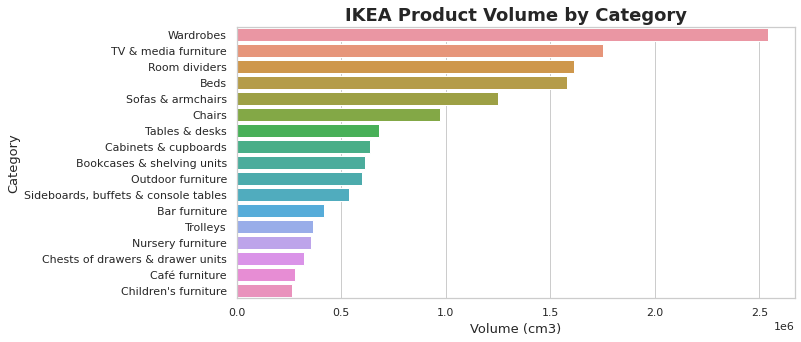

,category,volume
16,Wardrobes,2.540682e+06
13,TV & media furniture,1.751985e+06
10,Room dividers,1.615039e+06
1,Beds,1.580435e+06
12,Sofas & armchairs,1.247908e+06
5,Chairs,9.729201e+05
14,Tables & desks,6.808350e+05
3,Cabinets & cupboards,6.400732e+05
2,Bookcases & shelving units,6.135500e+05
9,Outdoor furniture,6.013222e+05


In [73]:
plt.figure(figsize=[10, 5])
result = df.groupby(["category"])['volume'].aggregate(np.mean).reset_index().sort_values('volume', ascending=False)

sns.barplot(data = result, x = 'volume', y='category', order=result.category)
plt.title('IKEA Product Volume by Category',fontsize=18, fontweight='bold')
plt.xlabel('Volume (cm3)', fontsize=13)
plt.ylabel('Category', fontsize=13)
plt.show()

result

pada perbandingan volume, wardrobes menempati urutan tertinggi yaitu 2,5e+6 cm disusul dengan TV & media furniture dan room divider

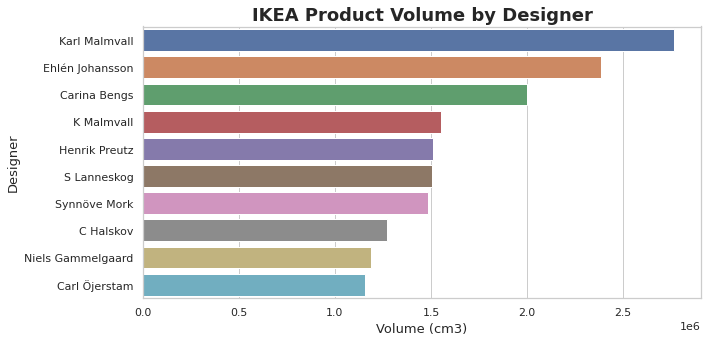

,designer,volume
41,Karl Malmvall,2.767772e+06
16,Ehlén Johansson,2.386333e+06
8,Carina Bengs,2.000180e+06
40,K Malmvall,1.552363e+06
26,Henrik Preutz,1.510552e+06
71,S Lanneskog,1.507300e+06
74,Synnöve Mork,1.485534e+06
6,C Halskov,1.271112e+06
60,Niels Gammelgaard,1.185910e+06
9,Carl Öjerstam,1.157608e+06


In [74]:
plt.figure(figsize=[10, 5])
result = df.groupby(["designer"])['volume'].aggregate(np.mean).reset_index().sort_values('volume', ascending=False)

sns.barplot(data = result, x = 'volume', y='designer', order=result.designer[:10])
plt.title('IKEA Product Volume by Designer',fontsize=18, fontweight='bold')
plt.xlabel('Volume (cm3)', fontsize=13)
plt.ylabel('Designer', fontsize=13)
plt.show()

result[:10]

designer yang membuat produk dengan volume yang paling besar adalah Karl Malmvall, Ehlen Johansson, dan Carina Bengs

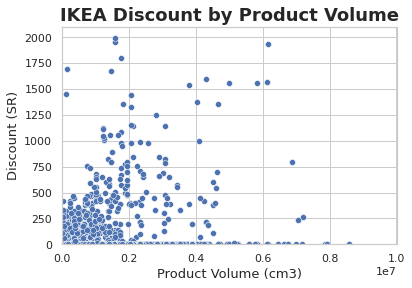

In [75]:
sns.scatterplot(x="volume", y="discount", data=df)
plt.title('IKEA Discount by Product Volume', fontsize = 18, fontweight='bold')
plt.xlabel('Product Volume (cm3)', fontsize = 13)
plt.ylabel('Discount (SR)', fontsize = 13)
plt.xlim(0, 10000000)
plt.ylim(0, 2100)
plt.show()

pada grafik teratas, walaupun sepertinya acak namun terlihat semakin besar volume produk berhubungan positif terhadap semakin besarnya jumlah diskon

,sellable,discount,no discount
0,Online,573,2370
1,Offline,1,18


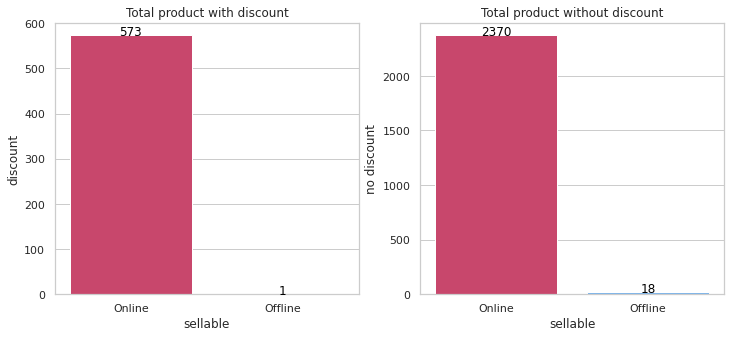

In [88]:
### Category - sellable online have discount
sellOnlineDisc = df[(df.discount_flag == True) & (df.sellable_online == True)]['category'].value_counts()
totDisc = sellOnlineDisc.sum()

### Category - sellable online dont have discount
dsellOnlineNoDisc = df[(df.discount_flag == False) & (df.sellable_online == True)]['category'].value_counts()
totNoDisc = dsellOnlineNoDisc.sum()

### Category - sellable offline have discount
offDisc = df[(df.discount_flag == True) & (df.sellable_online == False)]['category'].value_counts()
totOffDisc = offDisc.sum()

### Category - sellable offline no discount
offNoDisc = df[(df.discount_flag  == False) & (df.sellable_online == False)]['category'].value_counts()
totOffNoDisc = offNoDisc.sum()

### dataframe
dfDiscNoDisc = pd.DataFrame({'sellable': ['Online','Offline'],
                             'discount': [totDisc,totOffDisc],
                             'no discount': [totNoDisc,totOffNoDisc]})
display(dfDiscNoDisc)


plt.figure(figsize = (12,5))
colors = ['#DE3163','#66b3ff']
ax = plt.subplot(1,2,1)
sns.barplot(data = dfDiscNoDisc, x = 'sellable', y = 'discount', ax=ax, palette = colors)

for index, value in enumerate(dfDiscNoDisc.values):
    plt.text(index, value[1], value[1], color='black', ha="center") 

plt.title('Total product with discount') 

    
ax = plt.subplot(1,2,2)
sns.barplot(data = dfDiscNoDisc, x = 'sellable', y = 'no discount', ax =ax, palette = colors)

for index, value in enumerate(dfDiscNoDisc.values):
    plt.text(index, value[2], value[2], color='black', ha="center")

plt.title('Total product without discount') 
plt.show()  


pada grafik di atas jika dibandingkan antara produk yang diskon dan yang dijual secara online. mayoritas produk dijual secara online dengan 573 produk dijual diskon dan 2370 produk dijual tanpa diskon. hanya 1 produk yang didiskon dijual offline dan 18 produk dijual dijual offline tanpa diskon

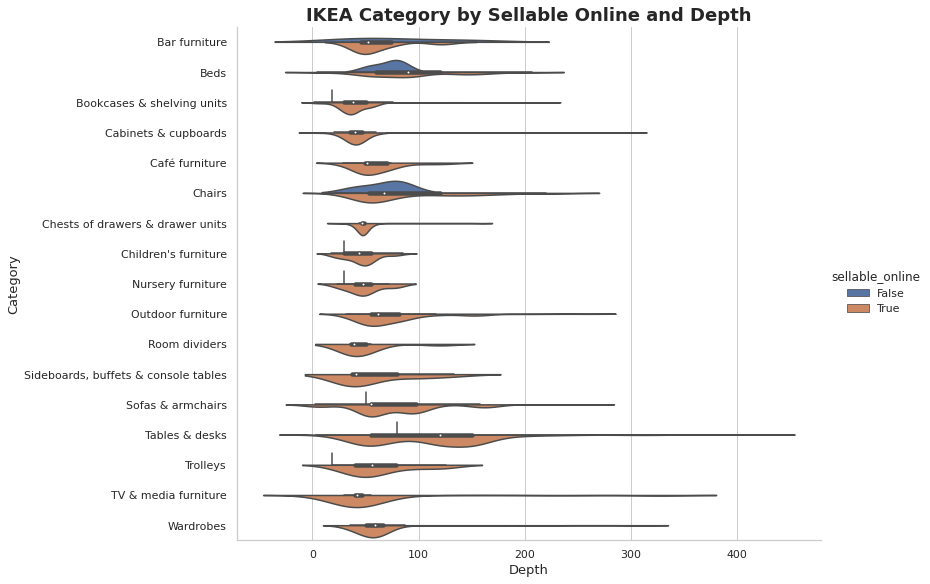

In [77]:
sns.catplot(y="category", x='depth', hue="sellable_online",
            kind="violin", split=True, data=df, height=8, aspect=1.5)
plt.title('IKEA Category by Sellable Online and Depth', fontsize = 18, fontweight='bold')
plt.xlabel('Depth', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.show()

pada grafik di atas terlihat tables & desks, TV & media furniture, serta wardrobe memiliki depth tertinggi dibandingkan kategori yang lain serta mayoritas dijual secara online. 

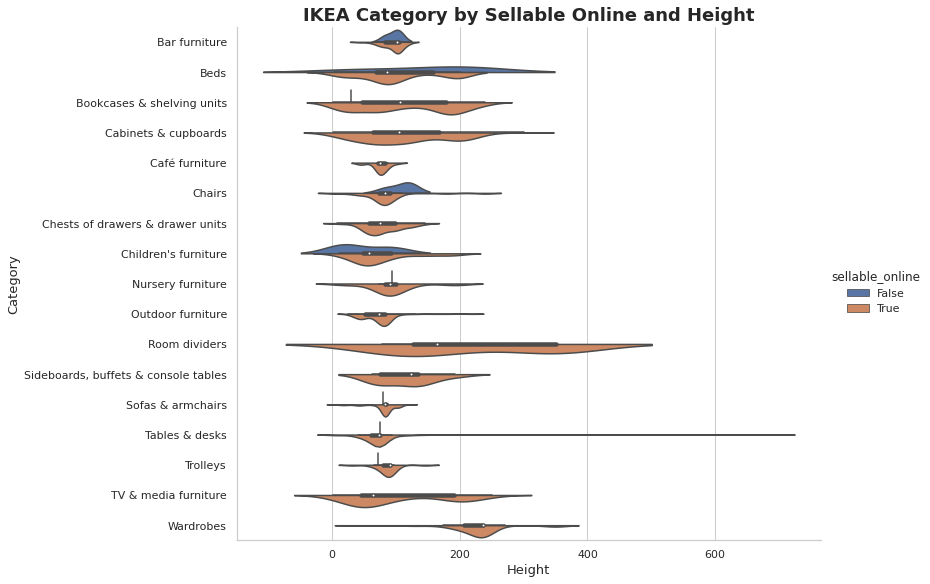

In [78]:
sns.catplot(y="category", x='height', hue="sellable_online",
            kind="violin", split=True, data=df, height=8, aspect=1.5)
plt.title('IKEA Category by Sellable Online and Height', fontsize = 18, fontweight='bold')
plt.xlabel('Height', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.show()

pada grafik di atas terlihat tables & desks, room dividers, serta wardrobe memiliki height tertinggi dibandingkan kategori yang lain serta mayoritas dijual secara online. 

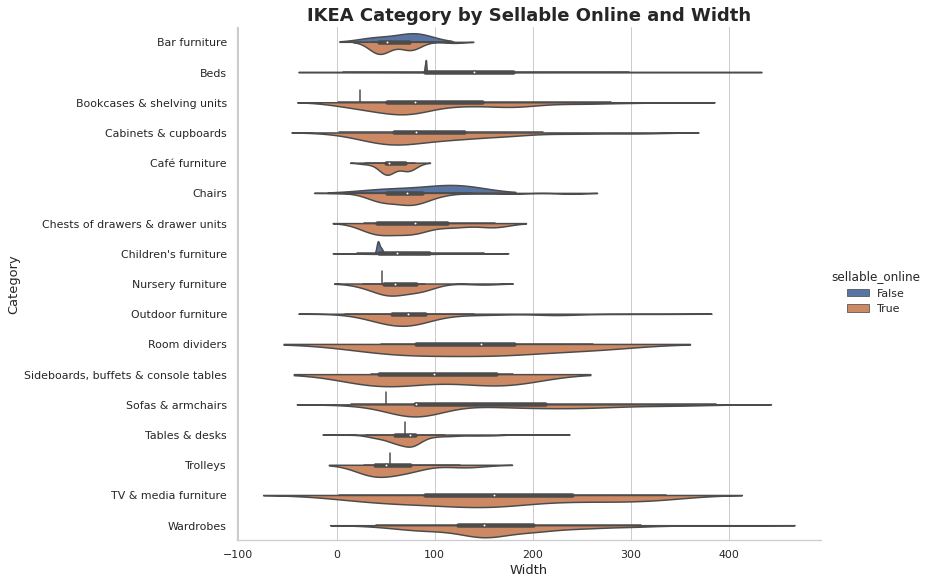

In [79]:
sns.catplot(y="category", x='width', hue="sellable_online",
            kind="violin", split=True, data=df, height=8, aspect=1.5)
plt.title('IKEA Category by Sellable Online and Width', fontsize = 18, fontweight='bold')
plt.xlabel('Width', fontsize = 13)
plt.ylabel('Category', fontsize = 13)
plt.show()

pada grafik di atas terlihat sofas & chairs, beds, serta wardrobe memiliki width tertinggi dibandingkan kategori yang lain serta mayoritas dijual secara online. 

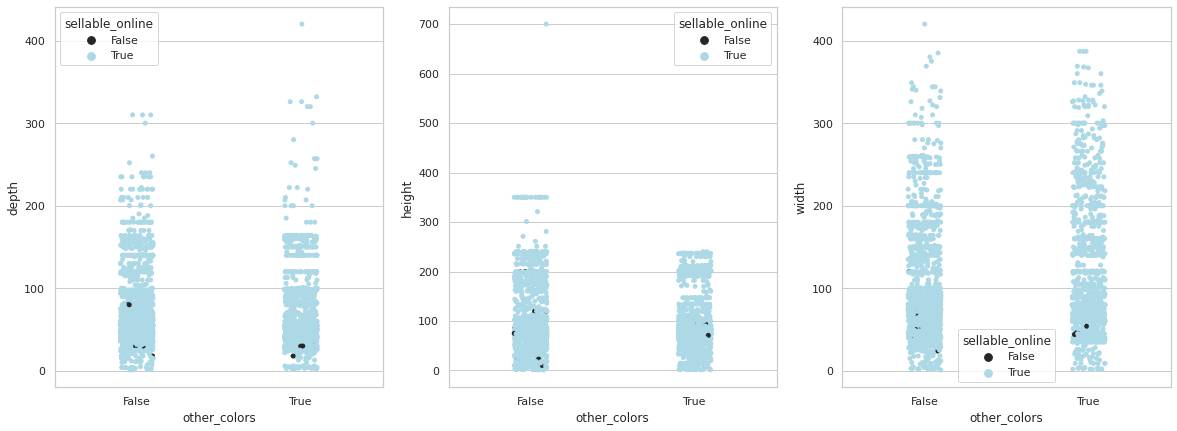

In [80]:
fig, axs = plt.subplots (1, 3, figsize=(20, 7))
sns.stripplot(x="other_colors", y="depth", hue="sellable_online",  data=df, ax=axs[0], color='lightblue')
sns.stripplot(x="other_colors", y="height", hue="sellable_online", data=df, ax=axs[1], color='lightblue')
sns.stripplot(x="other_colors", y="width", hue="sellable_online", data=df, ax=axs[2], color='lightblue')

pada perbandingan ketiga dimensi tersebut dengan ketersediaan pilihan warna dan keterjualan online, semua produk pada dimensi dan ketersediaan pilihan warna terlihat seimbang. sedangkan pada penjualan online hanya terlihat sedikit saja pada titik hitam

<Figure size 720x576 with 0 Axes>

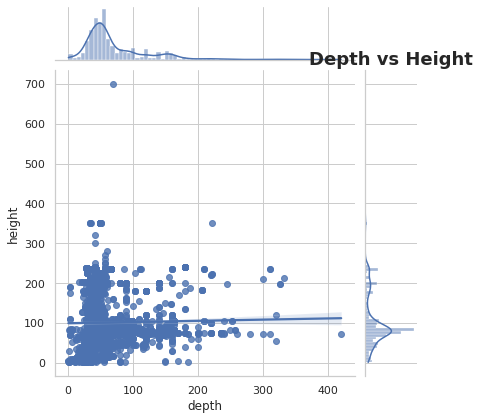

In [81]:
plt.figure(figsize=[10, 8])
sns.jointplot("depth", "height", data=df, kind='reg')
plt.title('Depth vs Height', fontsize = 18, fontweight='bold')
plt.xlabel('Depth (cm)', fontsize = 13)
plt.ylabel('Height (cm)', fontsize = 13)
plt.show()

perbandingan antara dimensi depth dan height, menunjukkan pola linear yang hampir absolut dengan semakin tinggi depth, maka height semakin meningkat

<Figure size 720x576 with 0 Axes>

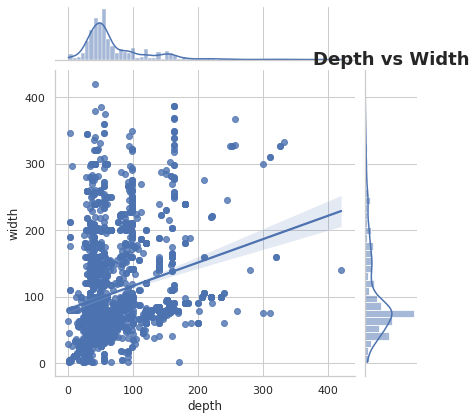

In [82]:
plt.figure(figsize=[10, 8])
sns.jointplot("depth", "width", data=df, kind='reg')
plt.title('Depth vs Width', fontsize = 18, fontweight='bold')
plt.xlabel('Depth (cm)', fontsize = 13)
plt.ylabel('Width (cm)', fontsize = 13)
plt.show()

pada perbandingan depth dan width, pola menunjukkan linear yang positif terhadap depth dan width

<Figure size 720x576 with 0 Axes>

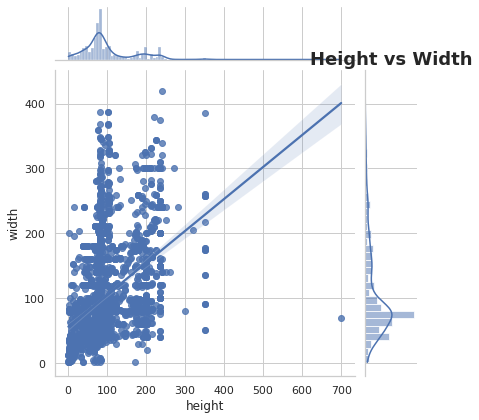

In [83]:
plt.figure(figsize=[10, 8])
sns.jointplot("height", "width", data=df, kind='reg')
plt.title('Height vs Width', fontsize = 18, fontweight='bold')
plt.xlabel('Height (cm)', fontsize = 13)
plt.ylabel('Width (cm)', fontsize = 13)
plt.show()

pada perbandingan dimensi height dan width, pola menunjukkan kecenderungan pola linear yang lebih berat pada width

### **Linearity Check**

In [84]:
df.head(2)

,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,description,designer,depth,height,width,volume
0,90420332,FREKVENS,Bar furniture,265.0,265.0,0.0,0,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,Bar table,Nicholai Wiig Hansen,51.0,99.0,51.0,257499.0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,Bar table,Francis Cayouette,140.0,105.0,80.0,1176000.0


price vs depth, height, width

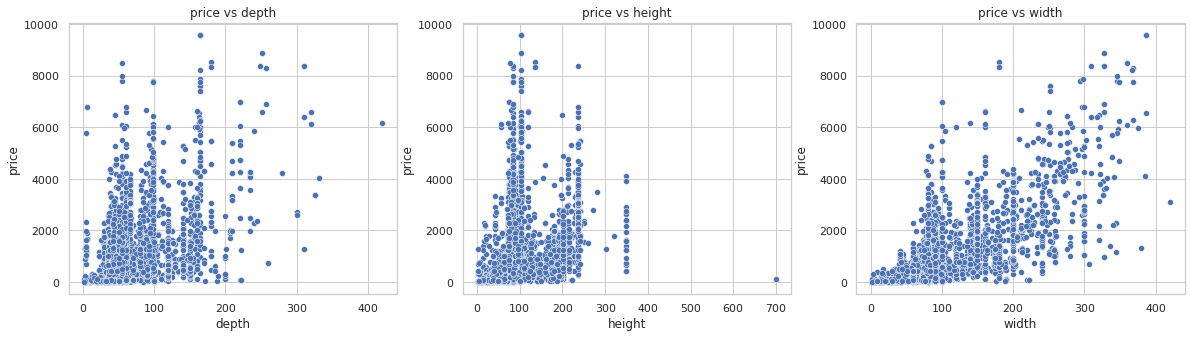

In [85]:
plt.figure(figsize = (20, 5))
ax = plt.subplot(1,3,1)
sns.scatterplot(x="depth", y="price", data=df, ax= ax);
plt.title('price vs depth')

ax = plt.subplot(1,3,2)
sns.scatterplot(x="height", y="price", data=df, ax= ax);
plt.title('price vs height')

ax = plt.subplot(1,3,3)
sns.scatterplot(x="width", y="price", data=df, ax= ax);
plt.title('price vs width')
plt.show()

pada perbandingan ketiga dimensi dengan harga, dimensi width menunjukkan pola linear yang positif terhadap harga dibandingkan dengan depth dan height

price vs volume, old_price, discount

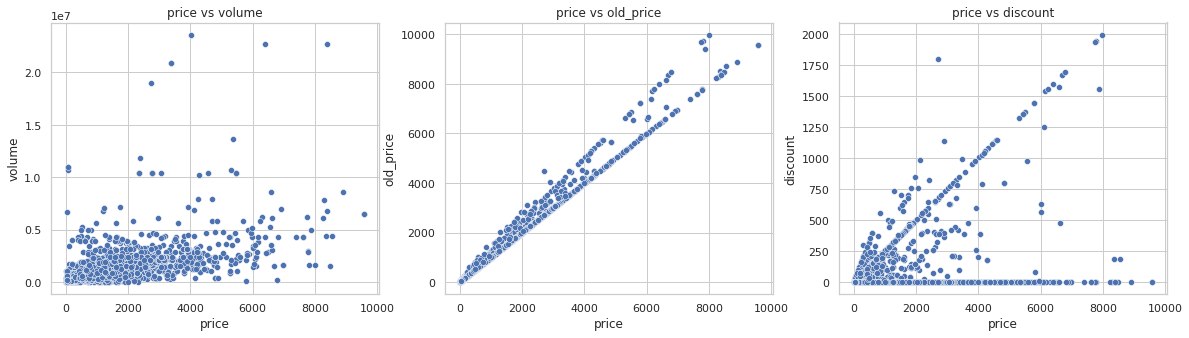

In [86]:
plt.figure(figsize = (20, 5))
ax = plt.subplot(1,3,1)
sns.scatterplot(x="price", y="volume", data=df, ax= ax);
plt.title('price vs volume')

ax = plt.subplot(1,3,2)
sns.scatterplot(x="price", y="old_price", data=df, ax= ax);
plt.title('price vs old_price')

ax = plt.subplot(1,3,3)
sns.scatterplot(x="price", y="discount", data=df, ax= ax);
plt.title('price vs discount')
plt.show()

grafik di atas membandingkan price dengan volume, old price, dan discount. price membentuk pola linear dengan old price dan discount karena memang fitur price berasal dari old price yang telah dikurangi diskon jadi sangat mengandung kolinearitas yang tinggi

sedangkan hubungan volume dengan price terlihat korelasi yang positif walaupun belum membentuk pola tertentu

### **2. Analysis Structure & Expected Analysis Result**

### **Correlation**

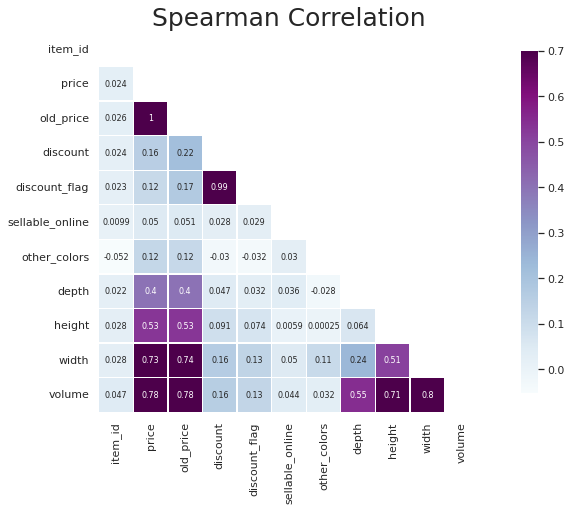

In [87]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 7))
plt.title('Spearman Correlation', fontsize=25)

sns.heatmap(df.corr(method='spearman'), linewidth=0.25, vmax=0.7, square=True, cmap='BuPu', 
           linecolor='w', annot=True, annot_kws={'size': 8}, mask=mask, cbar_kws={'shrink': .9})

Terdapat korelasi kuat antara dimensi besaran produk seperti depth (0,4), height (0,53), dan width (0,73) dengan harga. jika 3 dimensi itu digabungkan menjadi volume, volume memiliki korelasi paling kuat dengan harga (0,78) jika dibandingkan dengan 3 dimensi lain. 

produk-produk yang memiliki volume besar dan rata-rata harga yang tinggi adalah produk berkategori Wardrobes, beds, sofas & armchairs. selain itu, designer juga turut andil dalam mempengaruhi harga produk. produk yang di desain oleh Niels Gammelgaard, S Lanneskog rata-rata berharga 4000-6000 SR

keterjualan produk dengan harga yang tinggi juga lebih besar terdapat pada produk yang dijual secara online dan produk yang memiliki pilihan warna. dimana rata-rata harga produk yang dijual secara online dan terdapat pilihan warna adalah 1500 SR, sedangkan produk yang tidak dijual online dan hanya ada pilihan satu warna memiliki harga rata-rata 1300 

oleh itu kami menyarankan kepada manajemen agar dapat menampilkan harga produk yang dijual dengan memperhatikan volume produk, kategori produk, keterjualan online dan ketersediaan pilihan warna, serta designer produk.

harga produk yang ditampilkan dapat diberikan setelah dikurangi diskon atau dimarkup sesuai dengan karakteristik produk tersebut.